# Notebook to visualize training transforms for SELMA3D data

## Setup

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import sys
import tifffile as tiff
import torch

from monai.transforms import (
    CastToTyped,
    Compose,
    EnsureChannelFirstd,
    MapTransform,
    RandAffined,
    RandFlipd,
    RandGaussianNoised,
    RandGaussianSmoothd,
    RandRotate90d,
    RandScaleIntensityd,
    RandShiftIntensityd,
    ScaleIntensityRangePercentilesd,
    ThresholdIntensityd,
    ToTensord
)
from monai.data import Dataset, DataLoader


In [2]:
# get functions from other files
sys.path.append('/home/ads4015/ssl_project/preprocess_patches/src')
from selma3d_visualization_functions import ClampIntensityd, LoadTiffd, get_train_transforms, get_val_transforms, get_load_transforms


In [5]:
# set seed for reproducibility
random.seed(100)


In [ ]:
# define paths to data and create directories
data_root = '/midtier/paetzollab/scratch/ads4015/data_selma3d/small_patches'
save_root = '/midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp'
os.makedirs(save_root, exist_ok=True)

# define variables
data_types = ['ab_plaque', 'cfos', 'nucleus', 'vessel_eb', 'vessel_wga']
train_target = 200 # max number of patches for training
val_target = 50 # max number of patches for validation
patch_targets = {'train': train_target, 'val': val_target}
train_ratio = 0.8 # 80% train, 20% val


## Functions

In [7]:
# define transforms
train_transforms = get_train_transforms()
val_transforms = get_val_transforms()
load_transforms = get_load_transforms()


In [8]:
# visualization function
def visualize_patches(original, augmented, title):

    # get center slice
    center_z = original.shape[1] // 2

    # create figure
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    fig.suptitle(title, fontsize=12)

    # plot original
    axs[0].imshow(original[0, center_z], cmap='gray')
    axs[0].set_title('Original')
    axs[0].axis('off')

    # plot augmented
    axs[1].imshow(augmented[0, center_z], cmap='gray')
    axs[1].set_title('Augmented')
    axs[1].axis('off')
    
    # format and show plot
    plt.tight_layout()
    plt.show()


In [9]:
# function to plot number of samples from each image
def plot_patch_counts(patch_counts, title):

    # create plot
    fig, axs = plt.subplots(figsize=(12, 6))

    # create lists for labels, counts, and colors
    labels, counts, colors = [], [], []

    # define color mapping
    color_map = {
        'ab_plaque': 'tab:blue',
        'cfos': 'tab:orange',
        'nucleus': 'tab:green',
        'vessel_eb': 'tab:red',
        'vessel_wga': 'tab:purple'
    }

    # loop through samples in each dtype and add data to lists
    for dtype in sorted(patch_counts):
        for sample in sorted(patch_counts[dtype]):
            labels.append(f'{dtype} {sample}')
            counts.append(patch_counts[dtype][sample])
            colors.append(color_map.get(dtype, 'gray'))

    # create plot
    bars = axs.bar(labels, counts, color=colors)
    axs.set_title(title)
    axs.set_ylabel('Num patches')
    axs.set_xlabel('Sample')
    axs.set_ylim(top=max(counts) * 1.1)
    for bar, count in zip(bars, counts):
        axs.text(bar.get_x() + bar.get_width() / 2.0, bar.get_height(), str(count), ha='center', va='bottom', fontsize=8)
    plt.xticks(rotation=90, fontsize=8)
    plt.tight_layout()
    plt.show()
    


## Get data


TRAIN SAMPLES BY DATATYPE
ab_plaque: sample1, sample3, sample4
cfos: sample1, sample10, sample12, sample13, sample14, sample15, sample16, sample17, sample18, sample2, sample5, sample6, sample7, sample9
nucleus: sample1, sample2, sample4
vessel_eb: sample1, sample2, sample3, sample4, sample6, sample8, sample9
vessel_wga: sample1, sample2, sample3, sample4, sample7, sample8, sample9

VAL SAMPLES BY DATATYPE
ab_plaque: sample2
cfos: sample11, sample3, sample4, sample8
nucleus: sample3
vessel_eb: sample5, sample7
vessel_wga: sample5, sample6


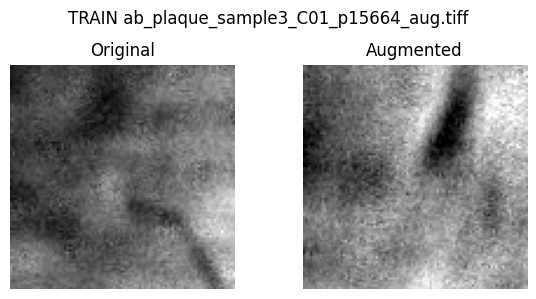

[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/ab_plaque_sample3_C01_p15664_aug.tiff


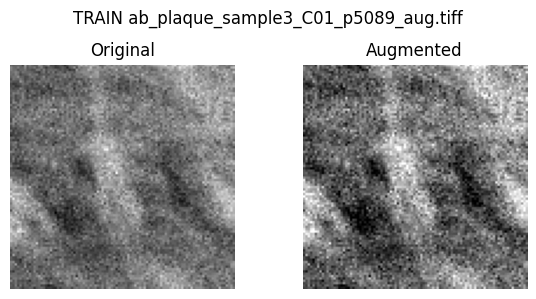

[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/ab_plaque_sample3_C01_p5089_aug.tiff


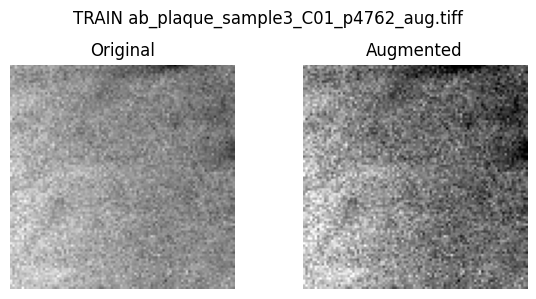

[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/ab_plaque_sample3_C01_p4762_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/ab_plaque_sample3_C01_p16070_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/ab_plaque_sample3_C01_p9931_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/ab_plaque_sample3_C01_p14214_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/ab_plaque_sample3_C01_p16478_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/ab_plaque_sample3_C01_p6465_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/ab_plaque_sample3_C01_p3812_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/ab_plaque_sample3_C01_p7904_aug.ti

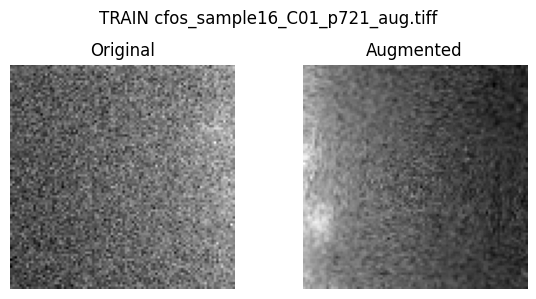

[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/cfos_sample16_C01_p721_aug.tiff


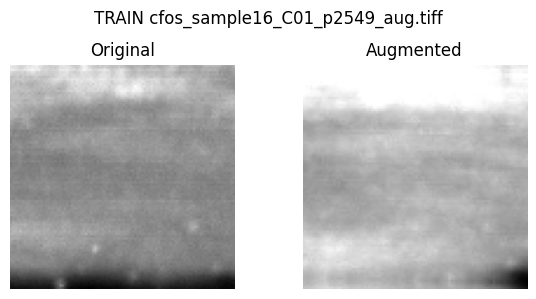

[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/cfos_sample16_C01_p2549_aug.tiff


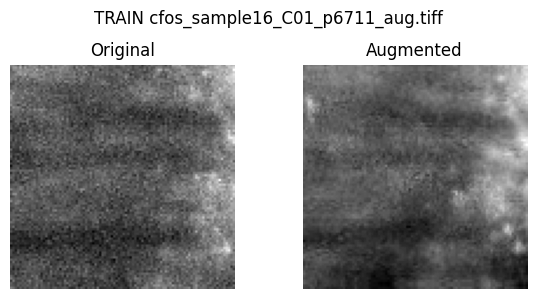

[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/cfos_sample16_C01_p6711_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/cfos_sample2_C01_p2267_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/cfos_sample2_C01_p6702_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/cfos_sample2_C01_p11126_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/cfos_sample1_C01_p7038_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/cfos_sample1_C01_p7883_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/cfos_sample1_C01_p5855_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/cfos_sample17_C01_p6669_aug.tiff
[TRAIN] saved patch: /midtier/paetzol

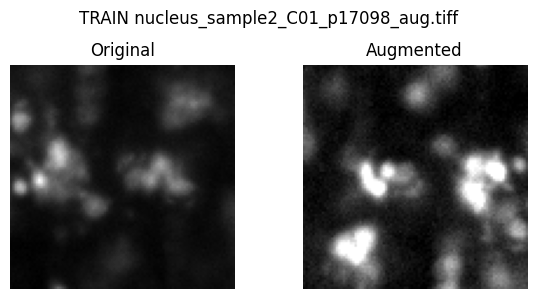

[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/nucleus_sample2_C01_p17098_aug.tiff


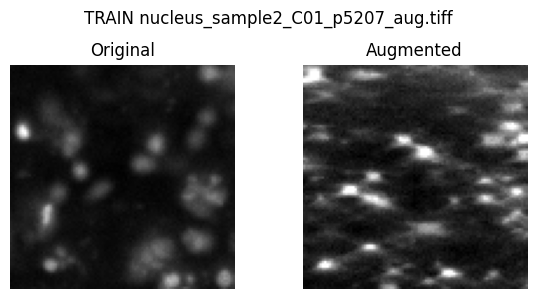

[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/nucleus_sample2_C01_p5207_aug.tiff


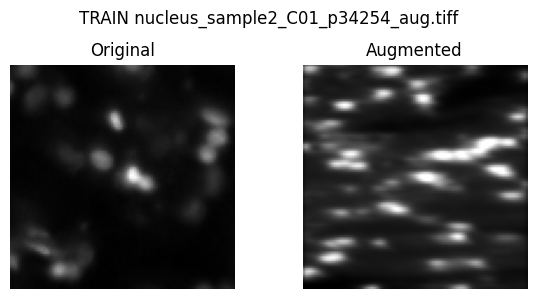

[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/nucleus_sample2_C01_p34254_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/nucleus_sample2_C01_p3612_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/nucleus_sample2_C01_p374_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/nucleus_sample2_C01_p18284_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/nucleus_sample2_C01_p30513_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/nucleus_sample2_C01_p5053_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/nucleus_sample2_C01_p6881_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/nucleus_sample2_C01_p21102_aug.tiff
[TRAIN] saved

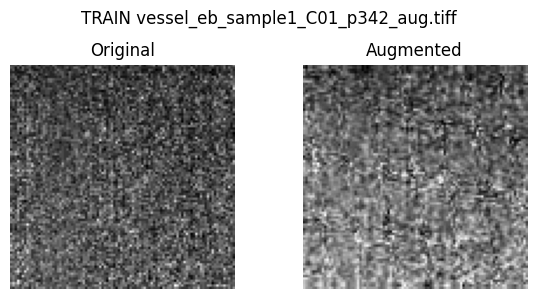

[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/vessel_eb_sample1_C01_p342_aug.tiff


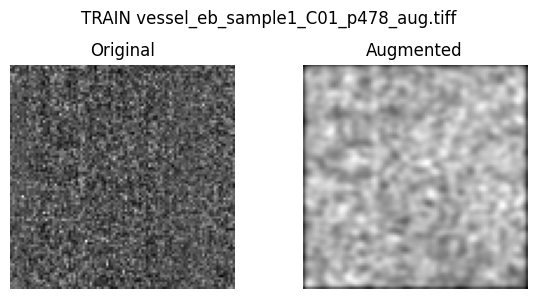

[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/vessel_eb_sample1_C01_p478_aug.tiff


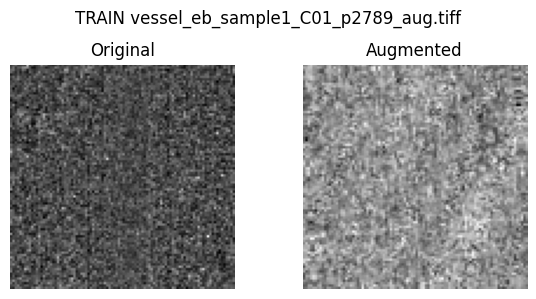

[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/vessel_eb_sample1_C01_p2789_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/vessel_eb_sample1_C01_p1709_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/vessel_eb_sample1_C01_p1614_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/vessel_eb_sample1_C01_p875_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/vessel_eb_sample8_C01_p152_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/vessel_eb_sample8_C01_p335_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/vessel_eb_sample8_C01_p137_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/vessel_eb_sample8_C01_p132_aug.tiff
[TRAI

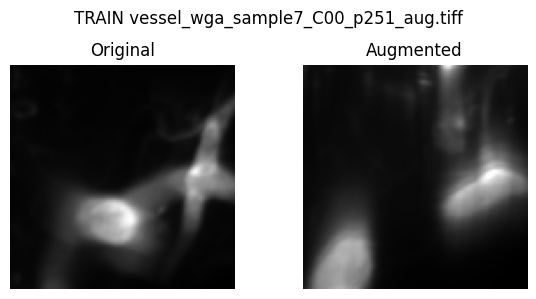

[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/vessel_wga_sample7_C00_p251_aug.tiff


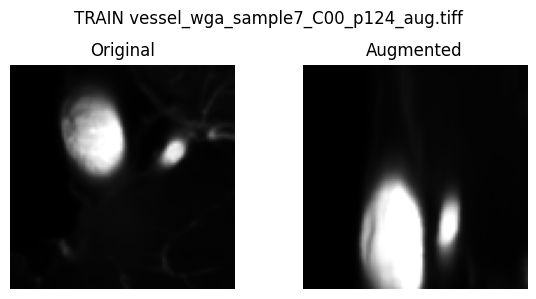

[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/vessel_wga_sample7_C00_p124_aug.tiff


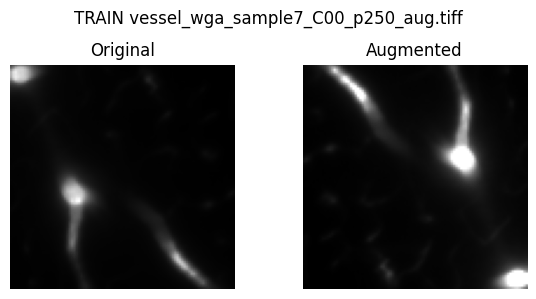

[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/vessel_wga_sample7_C00_p250_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/vessel_wga_sample7_C00_p69_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/vessel_wga_sample7_C00_p174_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/vessel_wga_sample7_C00_p96_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/vessel_wga_sample1_C00_p1759_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/vessel_wga_sample1_C00_p1591_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/vessel_wga_sample1_C00_p1247_aug.tiff
[TRAIN] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/train/vessel_wga_sample1_C00_p745_aug.tiff

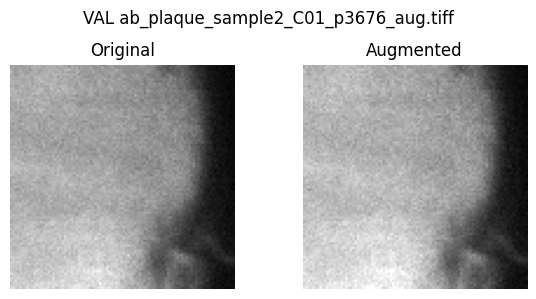

[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/ab_plaque_sample2_C01_p3676_aug.tiff


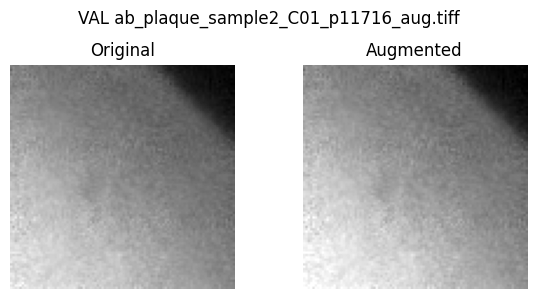

[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/ab_plaque_sample2_C01_p11716_aug.tiff


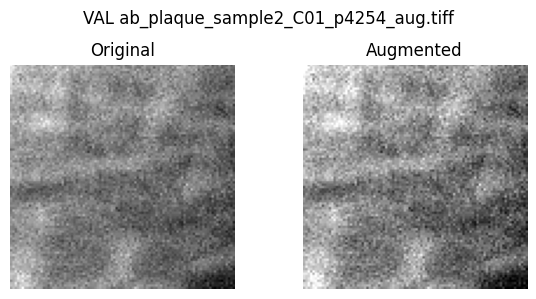

[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/ab_plaque_sample2_C01_p4254_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/ab_plaque_sample2_C01_p13979_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/ab_plaque_sample2_C01_p7989_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/ab_plaque_sample2_C01_p7946_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/ab_plaque_sample2_C01_p2845_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/ab_plaque_sample2_C01_p12733_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/ab_plaque_sample2_C01_p5389_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/ab_plaque_sample2_C01_p9171_aug.tiff


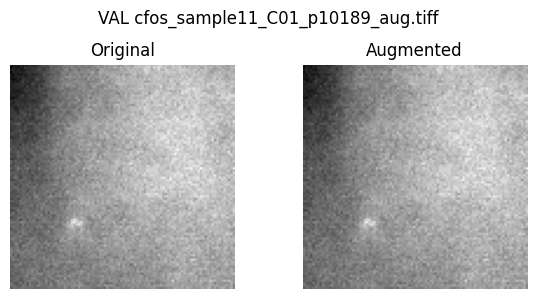

[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/cfos_sample11_C01_p10189_aug.tiff


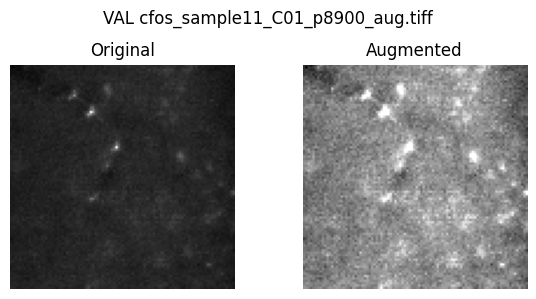

[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/cfos_sample11_C01_p8900_aug.tiff


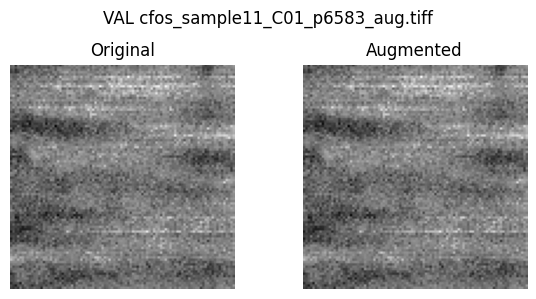

[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/cfos_sample11_C01_p6583_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/cfos_sample8_C01_p1222_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/cfos_sample8_C01_p4913_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/cfos_sample8_C01_p11993_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/cfos_sample3_C01_p5862_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/cfos_sample3_C01_p9730_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/cfos_sample4_C01_p7547_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/cfos_sample4_C01_p1734_aug.tiff


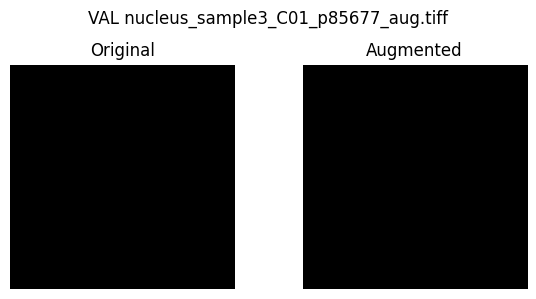

[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/nucleus_sample3_C01_p85677_aug.tiff


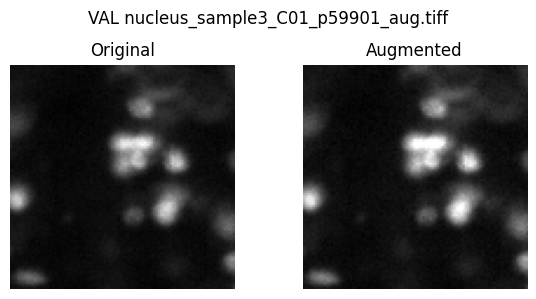

[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/nucleus_sample3_C01_p59901_aug.tiff


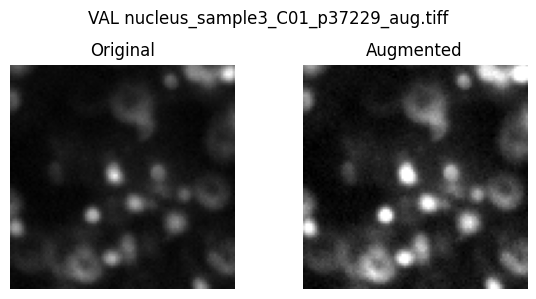

[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/nucleus_sample3_C01_p37229_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/nucleus_sample3_C01_p51906_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/nucleus_sample3_C01_p5194_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/nucleus_sample3_C01_p82264_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/nucleus_sample3_C01_p26551_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/nucleus_sample3_C01_p49768_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/nucleus_sample3_C01_p10995_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/nucleus_sample3_C01_p71469_aug.tiff


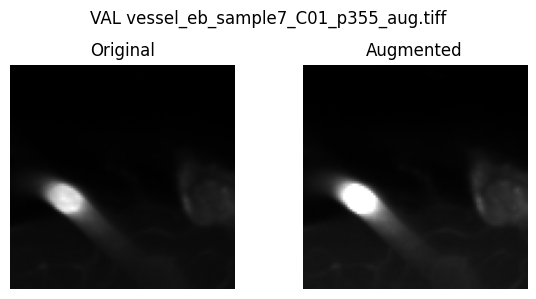

[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/vessel_eb_sample7_C01_p355_aug.tiff


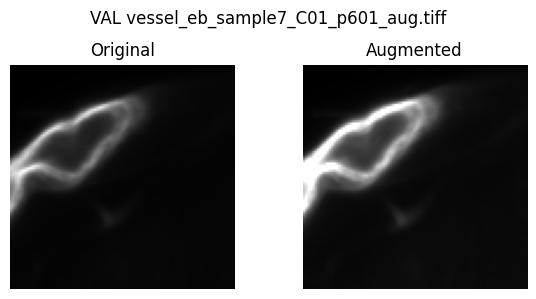

[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/vessel_eb_sample7_C01_p601_aug.tiff


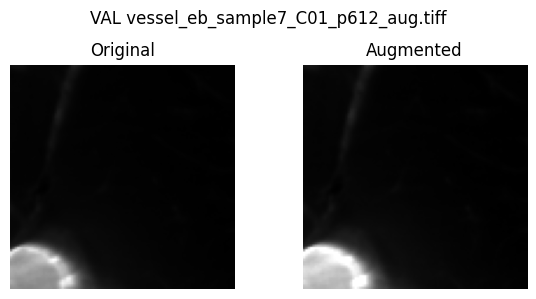

[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/vessel_eb_sample7_C01_p612_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/vessel_eb_sample7_C01_p665_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/vessel_eb_sample7_C01_p44_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/vessel_eb_sample5_C01_p75_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/vessel_eb_sample5_C01_p81_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/vessel_eb_sample5_C01_p168_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/vessel_eb_sample5_C01_p119_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/vessel_eb_sample5_C01_p128_aug.tiff


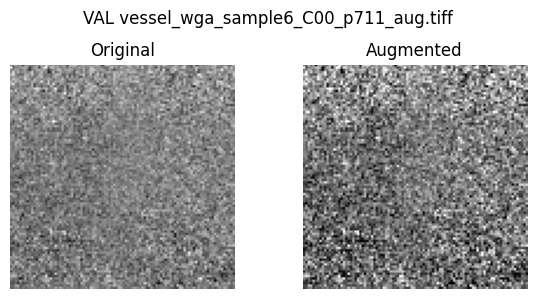

[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/vessel_wga_sample6_C00_p711_aug.tiff


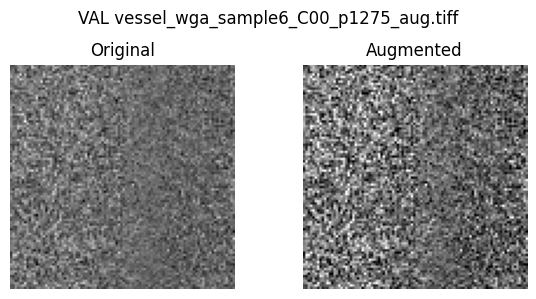

[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/vessel_wga_sample6_C00_p1275_aug.tiff


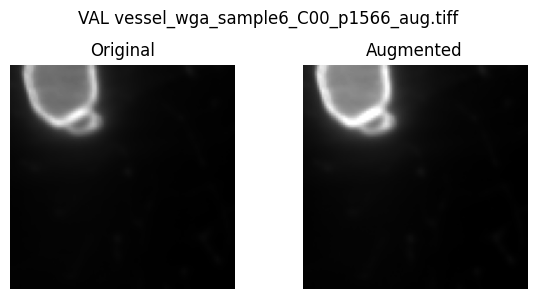

[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/vessel_wga_sample6_C00_p1566_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/vessel_wga_sample6_C00_p37_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/vessel_wga_sample6_C00_p505_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/vessel_wga_sample5_C00_p193_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/vessel_wga_sample5_C00_p261_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/vessel_wga_sample5_C00_p131_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/vessel_wga_sample5_C00_p273_aug.tiff
[VAL] saved patch: /midtier/paetzollab/scratch/ads4015/data_selma3d/lsm_fm_temp/val/vessel_wga_sample5_C00_p52_aug.tiff


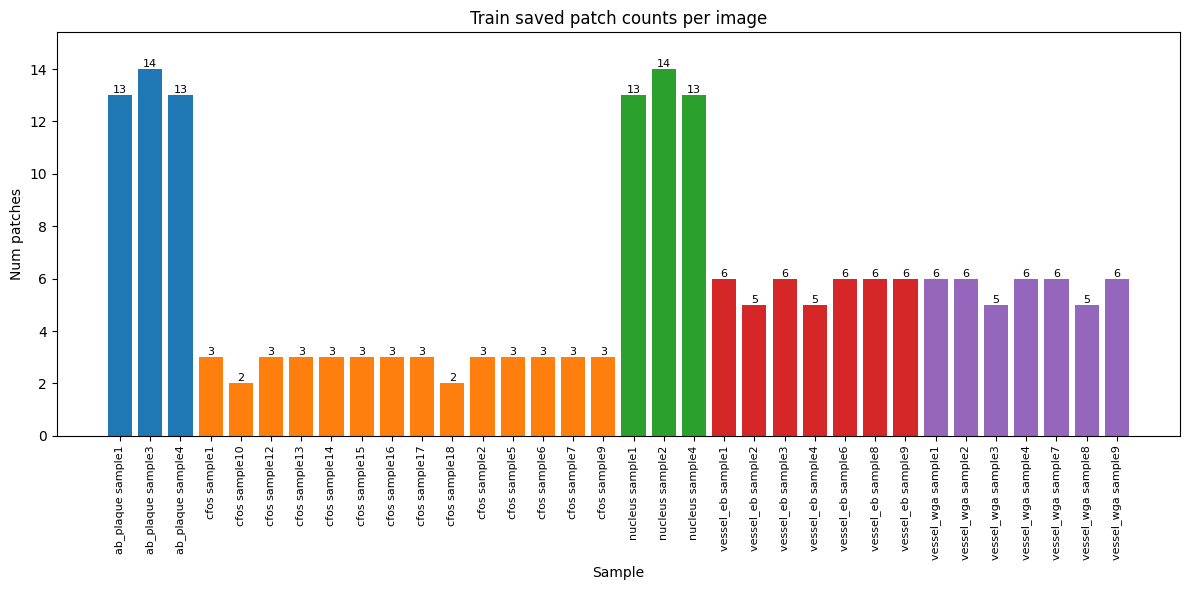

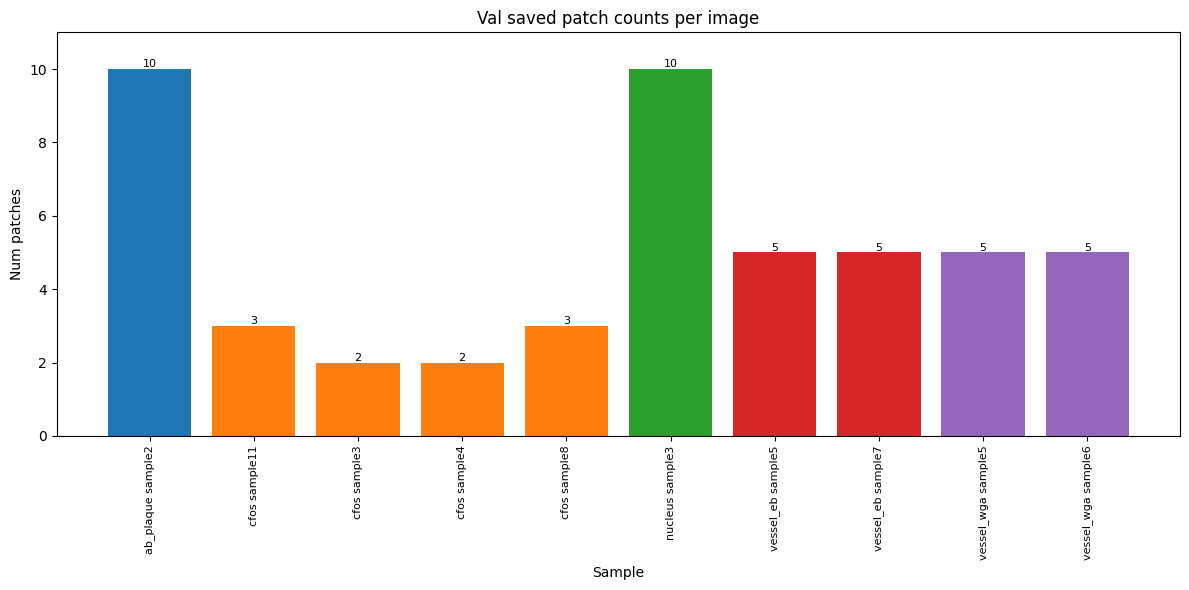

All patches saved


In [ ]:
# create lists to track image set assignment
patch_paths_by_phase = {'train': [], 'val': []}
sample_assignments = {'train': {}, 'val': {}}
saved_patch_counts = {'train': {}, 'val': {}}

# loop through datatypes
for dtype in data_types:

    # get all files from current datatype
    folder = os.path.join(data_root, dtype)
    all_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.tiff')]

    # group by sample to prevent overlap
    samples_dict = {}
    for f in all_files:
        sample = os.path.basename(f).split('_C')[0].split(dtype + '_')[-1]
        samples_dict.setdefault(sample, []).append(f)

    # using train_ratio, assign some samples to train and others to val
    sample_keys = list(samples_dict.keys())
    random.shuffle(sample_keys)
    split_idx = int(train_ratio * len(sample_keys))
    train_keys = sample_keys[:split_idx]
    val_keys = sample_keys[split_idx:]

    sample_assignments['train'][dtype] = train_keys
    sample_assignments['val'][dtype] = val_keys

    for phase, sample_keys_phase in zip(['train', 'val'], [train_keys, val_keys]):
        for s in sample_keys_phase:
            patch_paths_by_phase[phase].extend(samples_dict[s])
            saved_patch_counts[phase].setdefault(dtype, {})[s] = 0

# print sample usage
for phase in ['train', 'val']:
    print(f'\n{phase.upper()} SAMPLES BY DATATYPE')
    for dtype in data_types:
        samples = sample_assignments[phase].get(dtype, [])
        print(f'{dtype}: {", ".join(sorted(samples))}')


for phase in ['train', 'val']:

    # determine per-datatype max to balance contribution
    transforms = train_transforms if phase =='train' else val_transforms
    max_per_dtype = patch_targets[phase] // len(data_types)

    # create output directories
    output_dir = os.path.join(save_root, phase)
    os.makedirs(output_dir, exist_ok=True)

    for dtype in data_types:
        samples = sample_assignments[phase][dtype]
        dtype_patch_pool = [f for f in patch_paths_by_phase[phase] if os.path.basename(f).startswith(f'{dtype}_')]
        random.shuffle(dtype_patch_pool)

        # determine per-sample count inversely proportional to the number of samples
        sample_files = {s: [f for f in dtype_patch_pool if f'_{s}_' in os.path.basename(f)] for s in samples}
        total_files = sum(len(fs) for fs in sample_files.values())
        patches_per_sample = {}

        # reassign the remainder if number of patches is not evenly split across the number of samples
        base_patch_count = max_per_dtype // len(samples)
        remainder_patch_count = max_per_dtype % len(samples)
        for i, s in enumerate(samples):
            patches_per_sample[s] = base_patch_count + (1 if i < remainder_patch_count else 0)

        for s in samples:
            selected = random.sample(sample_files[s], min(patches_per_sample[s], len(sample_files[s])))
            for f in selected:
                sample = os.path.basename(f).split('_C')[0].split(dtype + '_')[-1]
                d = {'image': f}

                # load and augment patches
                try:
                    original = load_transforms(d)['image']
                    augmented = transforms(d)['image']
                    filename = os.path.basename(f).replace('.tiff', '_aug.tiff')
                    save_path = os.path.join(output_dir, filename)
                    tiff.imwrite(save_path, augmented.numpy(), dtype=np.float32)
                    saved_patch_counts[phase][dtype][sample] += 1

                    # display first 3 images from each datatype for train/val
                    if sum(saved_patch_counts[phase][dtype].values()) <= 3: 
                        visualize_patches(original.numpy(), augmented.numpy(), f'{phase.upper()} {filename}')

                    # indicate which patch was saved and where
                    print(f'[{phase.upper()}] saved patch: {save_path}')

                except Exception as e:
                    print(f'Failed to process {f}: {e}')

# plot saved patch counts
for phase in ['train', 'val']:
    plot_patch_counts(saved_patch_counts[phase], f'{phase.capitalize()} saved patch counts per image')

# indicate completion
print('All patches saved')
